## Overview
This notebook contains major data analysis that were conducted, including participants' game performance analysis, linguistic data preprocessing, summary statistics of linguistic data, as well as hypothesis testings.

We approached the collected data with four primary questions: \
(1) How well can people play the game? \
(2) How are explanations different from descriptions? \
(3) How well do the concepts invoked in the response map onto the task environment? \
(4) How are explanations associated with game performance?

In [1]:
import json
import numpy as np
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import time
import math
import os
import sys
os.getcwd()
sys.path.append("..")
sys.path.append("../../../stimuli")

import scipy.stats as stats

from scipy.spatial import distance
from IPython.core.pylabtools import figsize, getfigs

sns.set_context('talk')
sns.set_style('darkgrid')

from IPython.display import clear_output

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", message="numpy.dtype size changed")
warnings.filterwarnings("ignore", message="numpy.ufunc size changed")
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
from wordcloud import WordCloud
# import spacy library for processing linguistic responses
import spacy
nlp = spacy.load("en_core_web_sm")
all_stopwords = nlp.Defaults.stop_words

# set path to data directory
csv_dir = "../results/csv/"
json_dir = "../results/json/"

# Quesiton 1: How well can people play this game?

In [2]:
# read performance data - experiment 1
trial_data1 = pd.read_csv(csv_dir+'/physics_explanations_trialdata_pilot1.csv')
trial_data1 = trial_data1[["gameID", "launching_rho", "launching_force", "launching_ball_index", "scene", "held_out", "trialInd", "mouseAngle", "groundtruthAngle", "correct", "trajectory"]]
trial_data1['angular_error_degree'] = trial_data1.apply(lambda row: 57.3*abs((row.mouseAngle - row.groundtruthAngle + math.pi) % (2*math.pi) - math.pi), axis=1)
# trial_data1

In [3]:
# read performance data - experiment 2
trial_data2 = pd.read_csv(csv_dir+'/physics_explanations_trialdata_pilot2.csv')
trial_data2 = trial_data2[["gameID", "launching_rho", "launching_force", "launching_ball_index", "scene", "held_out", "trialInd", "mouseAngle", "groundtruthAngle", "correct", "trajectory"]]
trial_data2['angular_error_degree'] = trial_data2.apply(lambda row: 57.3*abs((row.mouseAngle - row.groundtruthAngle + math.pi) % (2*math.pi) - math.pi), axis=1)
# trial_data2

In [4]:
# concat trial data from two experiments
frames = [trial_data1, trial_data2]
trial_data = pd.concat(frames)

In [5]:
# calculate root mean squared error for each trial
RMSEs = []
for ind, data in trial_data.groupby('trialInd'):
    rmse = (data["angular_error_degree"] ** 2).mean() ** .5
    RMSEs.append(rmse)
RMSEs = pd.DataFrame(RMSEs, columns=['RMSE'])
RMSEs_diff = RMSEs-103.9

### stats test for RMSE of real playing vs. RMSE obtained from playing by chance

In [6]:
%load_ext rpy2.ipython

In [7]:
%%R -i RMSEs_diff

lm_model <- lm(formula = RMSE ~ 1, data = RMSEs_diff)
summary(lm_model)


Call:
lm(formula = RMSE ~ 1, data = RMSEs_diff)

Residuals:
    Min      1Q  Median      3Q     Max 
-14.536  -6.410  -2.037   4.651  37.250 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept) -55.5404     0.7592  -73.16   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 9.11 on 143 degrees of freedom



### stats test for RMSE Difference (Improvement)

In [8]:
# parse trials into early/late training and testing blocks by trial index
# 1-60 trials are considered early training trials
# 61-120 trials are late training trials
# 121-144 trials are testing trials
cond = []
gameIDs = []
early_errs = []
test_errs = []

for (held_out, gameID), cond_data in trial_data.groupby(['held_out', 'gameID']):
    early = cond_data[cond_data['trialInd']<60]
    test = cond_data[cond_data['trialInd']>=120]
    early_err = (early["angular_error_degree"] ** 2).mean() ** .5
    test_err = (test["angular_error_degree"] ** 2).mean() ** .5
    cond.append(held_out)
    gameIDs.append(gameID)
    early_errs.append(early_err)
    test_errs.append(test_err)

In [9]:
# display mean angular error in degrees by condition
data = {'held_out': cond,
        "gameID": gameIDs,
        'early': early_errs,
        'test': test_errs}
 
err_data = pd.DataFrame(data)
err_data = pd.melt(err_data, id_vars=['held_out', 'gameID'], value_vars=['early', 'test'], var_name='phase', value_name='RMSE')
err_data

,held_out,gameID,phase,RMSE
0,in-1,0178-f4f739d1-1666-4730-bcd8-c4b17613d1c3,early,39.278772
1,in-1,0258-464708fe-3042-4244-9cce-d35e9c89ef68,early,49.951558
2,in-1,0299-57faeb83-0ece-4603-925f-0cc4ce1f5f9a,early,33.761386
3,in-1,0383-e858c449-d434-4165-a4d8-69f3d6a80039,early,52.086362
4,in-1,1384-2ce045e4-e5c2-4d93-aca8-8c1ad4b4c2f8,early,57.370962
5,in-1,1413-beab6620-9a28-4ef4-bd04-2ff437e69e69,early,68.855657
6,in-1,1658-c23fb6de-7bd7-4c9f-96b9-0aee8d331029,early,51.930383
7,in-1,2387-946e6a02-90de-4c9a-8df9-b4110d337e6d,early,52.134742
8,in-1,2576-136693a5-e50c-4404-8ed2-a1f5297b0969,early,40.872193
9,in-1,2631-cee61fa4-304e-4891-bd5b-35cd8b195512,early,43.978448


In [ ]:
%%R -i err_data
library(ggeffects)
library(tidyverse)
library(lme4)
library(lmerTest)

lmer_model <- lmer(data = err_data, RMSE ~ phase*held_out + (1 | gameID))
summary(lmer_model)

In [ ]:
%%R

plot(ggpredict(lmer_model, c("phase", "held_out")))

### RMSE Plotting - Figure 2B

In [10]:
# parse trials into early/late training and testing blocks by trial index
# 1-60 trials are considered early training trials
# 61-120 trials are late training trials
# 121-144 trials are testing trials
cond = []
early_errs = []
late_errs = []
test_errs = []

for held_out, cond_data in trial_data.groupby('held_out'):
    early = cond_data[cond_data['trialInd']<60]
    late = cond_data[(cond_data['trialInd']>=60) & (cond_data['trialInd']<120)]
    test = cond_data[cond_data['trialInd']>=120]
    early_err = (early["angular_error_degree"] ** 2).mean() ** .5
    late_err = (late["angular_error_degree"] ** 2).mean() ** .5
    test_err = (test["angular_error_degree"] ** 2).mean() ** .5
    cond.append(held_out)
    early_errs.append(early_err)
    late_errs.append(late_err)
    test_errs.append(test_err)

In [11]:
# display mean angular error in degrees by condition
data = {'held_out': cond,
        'early': early_errs,
        'late': late_errs,
        'test': test_errs}
 
err_data = pd.DataFrame(data)
err_data

,held_out,early,late,test
0,in-1,53.300578,41.767375,47.946562
1,in-2,55.412021,44.520264,34.915740
2,in-3,57.610774,48.064488,35.263422
3,out-1,58.323775,44.893408,57.391399
4,out-2,55.760281,40.764677,37.235967
5,out-3,56.889809,45.258544,31.974931


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


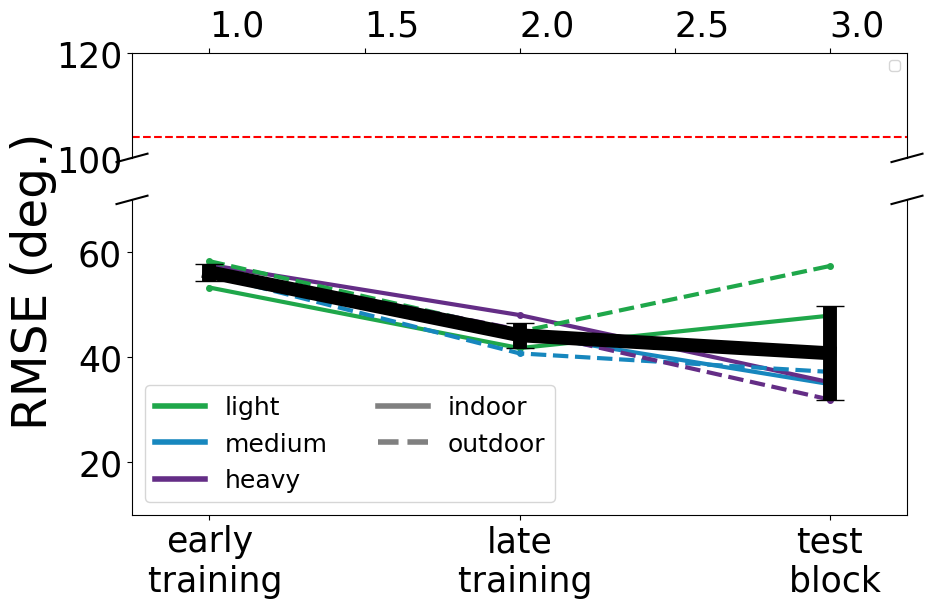

In [12]:
import matplotlib.gridspec as gridspec
plt.style.use('default')
# set colors for different conditions
cdict = {'in-1': '#1FA74A', 'in-2': '#1787BE', 'in-3': '#642D86', 'out-1': '#1FA74A', 'out-2': '#1787BE', 'out-3': '#642D86'}

x = [1, 2, 3]
conds = []
err_plots = []
means = []


ylim  = [100, 120]
ylim2 = [10, 70]
ylimratio = (ylim[1]-ylim[0])/(ylim2[1]-ylim2[0]+ylim[1]-ylim[0])
ylim2ratio = (ylim2[1]-ylim2[0])/(ylim2[1]-ylim2[0]+ylim[1]-ylim[0])
gs = gridspec.GridSpec(2, 1, height_ratios=[ylimratio, ylim2ratio])
fig = plt.figure(figsize=(10,6))
ax = fig.add_subplot(gs[0])
ax2 = fig.add_subplot(gs[1])

for held_out, cond_data in err_data.groupby('held_out'):
    y = cond_data[['early', 'late', 'test']].values[0]
    means.append(y)
    if held_out.startswith('in'): style = '-'
    else: style = '--'
    this_err = ax2.plot(
      x, 
      y, 
      marker='o', 
      color= cdict[held_out], 
      markersize=4, 
      linewidth=3, 
      linestyle=style)
    err_plots.append(this_err)
    conds.append(held_out)

means = np.array(means)
total_err = ax2.errorbar(
  x=x, 
  y=np.mean(means, axis=0), 
  yerr=np.std(means, axis=0), 
  capsize=10,
  marker='o', 
  color= 'black', 
  markersize=4, 
  linewidth=10, 
  linestyle='-')
conds.append(held_out)

ax.set_ylim(ylim)
ax2.set_ylim(ylim2)
plt.subplots_adjust(hspace=0.2)

ax.spines['bottom'].set_visible(False)
ax2.spines['top'].set_visible(False)
ax.xaxis.tick_top()
ax.tick_params(labeltop='off')
ax2.xaxis.tick_bottom()

ax2.set_ylabel('RMSE (deg.)', fontsize=35)
ax2.yaxis.set_label_coords(0.05, 0.5, transform=fig.transFigure)

kwargs = dict(color='k', clip_on=False)
xlim = [0.75, 3.25]
dx = .02*(xlim[1]-xlim[0])
dy = .01*(ylim[1]-ylim[0])/ylimratio
ax.plot((xlim[0]-dx,xlim[0]+dx), (ylim[0]-dy,ylim[0]+dy), **kwargs)
ax.plot((xlim[1]-dx,xlim[1]+dx), (ylim[0]-dy,ylim[0]+dy), **kwargs)
dy = .01*(ylim2[1]-ylim2[0])/ylim2ratio
ax2.plot((xlim[0]-dx,xlim[0]+dx), (ylim2[1]-dy,ylim2[1]+dy), **kwargs)
ax2.plot((xlim[1]-dx,xlim[1]+dx), (ylim2[1]-dy,ylim2[1]+dy), **kwargs)
ax.set_xlim(xlim)
ax2.set_xlim(xlim)
ax2.set_xticks(x) 
ax2.set_xticklabels(['early\n training','late\n training','test\n block'])
ax.axhline(y=103.9, color='r', linestyle='--')
ax.tick_params(axis='both', which='major', labelsize=25)
ax2.tick_params(axis='both', which='major', labelsize=25)

from matplotlib.lines import Line2D

legend_elements = [Line2D([0], [0], color='#1FA74A', lw=4, label='light'),
                   Line2D([0], [0], color='#1787BE', lw=4, label='medium'),
                   Line2D([0], [0], color='#642D86', lw=4, label='heavy'),
                   Line2D([0], [0], color='gray', lw=4, label='indoor', linestyle='-'),
                   Line2D([0], [0], color='gray', lw=4, label='outdoor', linestyle='--')]

ax2.legend(handles=legend_elements, prop={'size': 18}, ncol=2)
ax.legend()
plt.setp( ax.xaxis.get_majorticklabels(), ha="left" )

plt.show()
fig.savefig('./rmse.pdf')

### mean RMSE across participants in different stages of the game (early training, late training, and test block)

In [13]:
# left-to-right represents mean RMSE across participants in different stages
# early training: 56.22 degrees
# late training: 44.21 degrees
# testing: 40.79 degrees
np.mean(means, axis=0)

array([56.21620616, 44.21145919, 40.78800351])

# Question 2: How are explanations different from descriptions?

In [14]:
# read linguistic data
df_explanations = pd.read_csv(csv_dir + 'pedagogy_exp2_outputs.csv')
df_descriptions = pd.read_csv(csv_dir + 'baseline_exp1_outputs.csv')

## Helper functions for preprocessing linguistic data

In [15]:
# Define helper functions for preprocessing
def to_doc(words:tuple) -> spacy.tokens.Doc:
    # Create SpaCy documents by joining the words into a string
    return nlp(' '.join(words))

def remove_stops(doc) -> list:
    # Filter out stop words by using the `token.is_stop` attribute
    return [token.text for token in doc if not token.is_stop]

def remove_puncts(doc) -> list:
    # Filter out stop words by using the `token.is_stop` attribute
    return [token.text for token in doc if not token.is_punct]

def remove_stops_puncts(doc) -> list:
    # Filter out stop words by using the `token.is_stop` attribute
    return [token.text for token in doc if (not token.is_stop and not token.is_punct)]

def lemmatize(doc) -> list:
    # Take the `token.lemma_` of each non-stop word
    return [token.lemma_ for token in doc if (not token.is_stop and not token.is_punct)]

### Preprocessing descriptions

In [16]:
# create documents for all descriptions
df_descriptions["doc"] = list(nlp.pipe(df_descriptions['response']))

# apply removing stop words to all
df_descriptions['removed_stops'] = list(map(remove_stops, df_descriptions.doc))

# apply removing punctuations to all
df_descriptions['removed_puncts'] = list(map(remove_puncts, df_descriptions.doc))

# apply removing stop words & punctuations to all
df_descriptions['removed_stops_puncts'] = list(map(remove_stops_puncts, df_descriptions.doc))

# apply lemmatization to all
df_descriptions['lemmatized'] = list(map(lemmatize, df_descriptions.doc))

### Preprocessing explanations

In [17]:
# create documents for explanations
df_explanations["doc"] = list(nlp.pipe(df_explanations['response']))

# apply removing stop words to all
df_explanations['removed_stops'] = list(map(remove_stops, df_explanations.doc))

# apply removing punctuations to all
df_explanations['removed_puncts'] = list(map(remove_puncts, df_explanations.doc))

# apply removing stop words & punctuations to all
df_explanations['removed_stops_puncts'] = list(map(remove_stops_puncts, df_explanations.doc))

# apply lemmatization to all
df_explanations['lemmatized'] = list(map(lemmatize, df_explanations.doc))

# Simple word cloud frequency calculation

In [18]:
# set up words for explanations wordcloud
exp_list = df_explanations['response'].to_list()
exp_str = ' '.join(exp_list)

# set up words for descriptions wordcloud
des_list = df_descriptions['response'].to_list()
des_str = ' '.join(des_list)

## Getting normalized word frequencies

Take top 30 most frequent words from each condition

### Description condition normalized word frequencies

In [19]:
# calculate description normalized word frequencies
des_fr = WordCloud().generate(des_str)
des_wc_fr_df = pd.DataFrame([{"word": w, "des_frequency": s} for w,s in des_fr.words_.items()])
des_wc_fr_df.sort_values(by='des_frequency', ascending=False)

,word,des_frequency
0,ball,1.000000
1,game,0.426160
2,different,0.286920
3,circle,0.270042
4,catch,0.198312
5,arrow,0.160338
6,paddle,0.147679
7,move,0.139241
8,will,0.126582
9,one,0.122363


### Explanation condition normalized word frequencies

In [20]:
# calculate explanation normalized word frequencies
exp_fr = WordCloud().generate(exp_str)
exp_wc_fr_df = pd.DataFrame([{"word": w, "exp_frequency": s} for w,s in exp_fr.words_.items()])
exp_wc_fr_df.sort_values(by='exp_frequency', ascending=False)

,word,exp_frequency
0,ball,1.000000
1,will,0.306773
2,room,0.294821
3,gravity,0.282869
4,arrow,0.258964
5,paddle,0.191235
6,direction,0.159363
7,right,0.155378
8,wind,0.139442
9,go,0.139442


In [21]:
# descriptions vs. explanations
merged_fr = pd.merge(des_wc_fr_df, exp_wc_fr_df, how="outer")
merged_fr['freq_diff'] = merged_fr['exp_frequency'] - merged_fr['des_frequency']

In [22]:
# sort the frequency difference and select the top-10
merged_fr = merged_fr.sort_values(by='freq_diff', ascending=False)
top_merged_10_df = merged_fr[:10]

In [23]:
# select the bottom-10
bottom_merged_10_df = (merged_fr.sort_values(by='freq_diff', ascending=True))[:10]

### Normalized Word Frequency Plotting - Figure 3

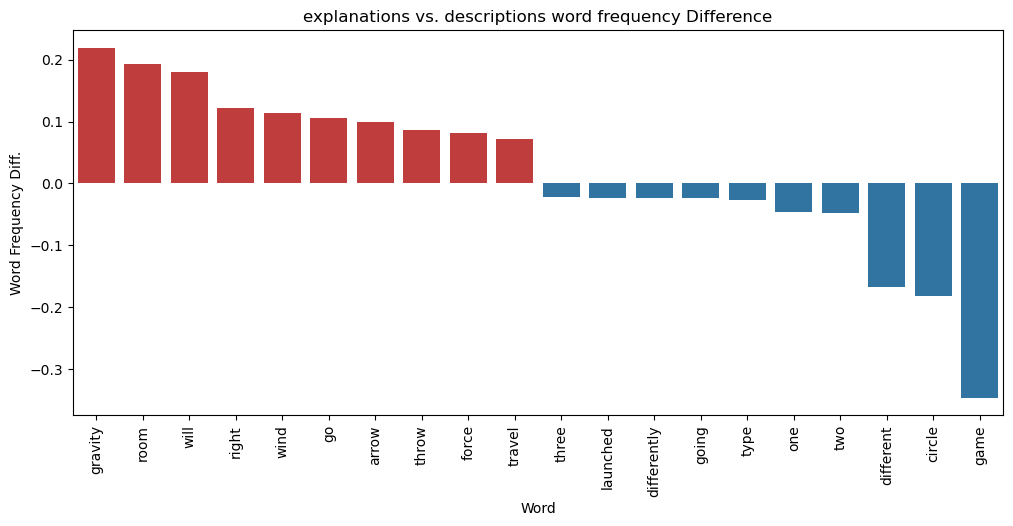

In [24]:
# concat top and bottom 10 frequency differences
bottom_merged_10_df = bottom_merged_10_df.sort_values(by='freq_diff', ascending=False)
top_bottom_10_merged = pd.concat([top_merged_10_df, bottom_merged_10_df])

palette_frq = []
for diff in top_bottom_10_merged['freq_diff']:
    if diff > 0:
        palette_frq.append('tab:red')
    else:
        palette_frq.append('tab:blue')

plt.figure(figsize=(12, 5))
plt.title("explanations vs. descriptions word frequency Difference")
ax = sns.barplot(x="word", y="freq_diff", data=top_bottom_10_merged, palette=palette_frq)
ax.grid(False)
ax.set_facecolor('white')
ax.set_xlabel("Word")
ax.set_ylabel("Word Frequency Diff.")
labels = ax.set_xticklabels(ax.get_xticklabels(),rotation = 90)

## Word Counts

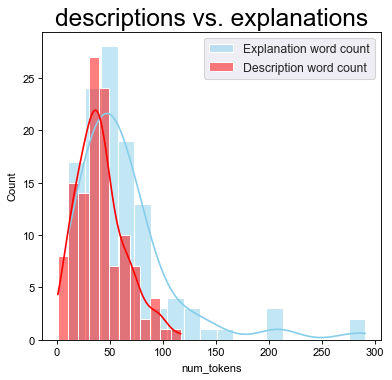

In [25]:
# Sum the number of tokens in each Doc for explanations
df_explanations['num_tokens'] = [len(token) for token in df_explanations.removed_puncts]

# Sum the number of tokens in each Doc for descriptions
df_descriptions['num_tokens'] = [len(token) for token in df_descriptions.removed_puncts]


plt.figure(figsize=(12, 5), dpi=80)
plt.subplot(1, 2, 1)
# set a grey background (use sns.set_theme() if seaborn version 0.11.0 or above)
sns.set(style="darkgrid")
sns.histplot(data=df_explanations, x="num_tokens", color="skyblue", label="Explanation word count", kde=True)
sns.histplot(data=df_descriptions, x="num_tokens", color="red", label="Description word count", kde=True)
plt.title('descriptions vs. explanations', fontsize=22)
plt.legend() 
plt.show()

### Mean word counts for descriptions and explanations

In [26]:
# mean word counts for descriptions
df_descriptions['num_tokens'].mean()

41.11666666666667

In [27]:
# mean word counts for explanations
df_explanations['num_tokens'].mean()

63.152542372881356

## Statistical testing for word counts difference

In [28]:
df_descriptions["domain"] = "des"
df_explanations["domain"] = "exp"

explanation_numTokens = df_explanations[['num_tokens', 'domain']]
descriptions_numTokens = df_descriptions[['num_tokens', 'domain']]
df_concat = pd.concat([explanation_numTokens, descriptions_numTokens])

### Linear mixed-effect model

In [29]:
%Rpush df_concat

In [30]:
%%R
library(tidyverse)
library(lme4)
library(lmerTest)
myPrediction <- lm(data = df_concat, num_tokens ~ domain)
summary(myPrediction)

R[write to console]: ── Attaching packages ─────────────────────────────────────── tidyverse 1.3.1 ──

R[write to console]: ✔ ggplot2 3.3.6     ✔ purrr   0.3.4
✔ tibble  3.1.7     ✔ dplyr   1.0.9
✔ tidyr   1.2.0     ✔ stringr 1.4.0
✔ readr   2.1.2     ✔ forcats 0.5.1

R[write to console]: ── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

R[write to console]: Loading required package: Matrix

R[write to console]: 
Attaching package: ‘Matrix’


R[write to console]: The following objects are masked from ‘package:tidyr’:

    expand, pack, unpack


R[write to console]: Error: package or namespace load failed for ‘lme4’ in loadNamespace(j <- i[[1L]], c(lib.loc, .libPaths()), versionCheck = vI[[j]]):
 there is no package called ‘nloptr’




Error: package or namespace load failed for ‘lme4’ in loadNamespace(j <- i[[1L]], c(lib.loc, .libPaths()), versionCheck = vI[[j]]):
 there is no package called ‘nloptr’


RInterpreterError: Failed to parse and evaluate line 'library(tidyverse)\nlibrary(lme4)\nlibrary(lmerTest)\nmyPrediction <- lm(data = df_concat, num_tokens ~ domain)\nsummary(myPrediction)\n'.
R error message: 'Error: package or namespace load failed for ‘lme4’ in loadNamespace(j <- i[[1L]], c(lib.loc, .libPaths()), versionCheck = vI[[j]]):\n there is no package called ‘nloptr’'

### Jensen-Shannon Distance

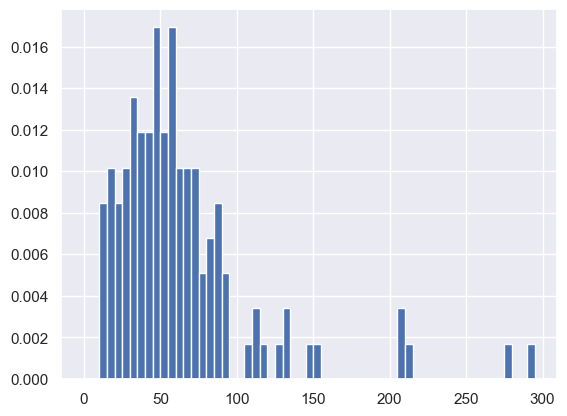

In [31]:
# Sum the number of tokens in each Doc for pedagogy
x_explanations, bins, p = plt.hist(df_explanations["num_tokens"].tolist(), bins=np.arange(0, 300, 5), density=True)

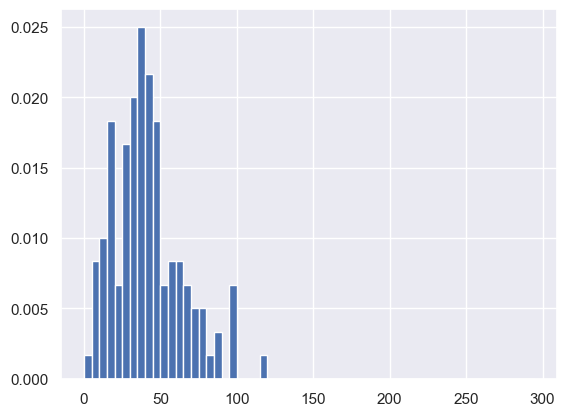

In [32]:
x_descriptions, bins, p = plt.hist(df_descriptions["num_tokens"].tolist(), bins=np.arange(0, 300, 5), density=True)

In [33]:
distance.jensenshannon(x_explanations, x_descriptions)

0.32942278316588164

In [34]:
import random

random.seed(11) # fix random state
dist_list = []
num_list = df_explanations['num_tokens'].tolist()+df_descriptions['num_tokens'].tolist()
for i in range(1000):
    rand_num_list = random.sample(num_list, len(num_list))
    first_half = rand_num_list[:len(rand_num_list)//2]
    second_half = rand_num_list[len(rand_num_list)//2:]
    x_first, bins, p = plt.hist(first_half, bins=np.arange(0, 300, 5), density=True)
    plt.close()
    x_second, bins, p = plt.hist(second_half, bins=np.arange(0, 300, 5), density=True)
    plt.close()
    jsd_dist = distance.jensenshannon(x_first, x_second)
    dist_list.append(jsd_dist)

### JSD p-value

In [35]:
# p-value is less than 0.05
larger_elements = [element for element in dist_list if element > 0.3385100824023593]
number_of_elements = len(larger_elements)
p_value = number_of_elements/len(dist_list)
p_value

0.016

<AxesSubplot:ylabel='Count'>

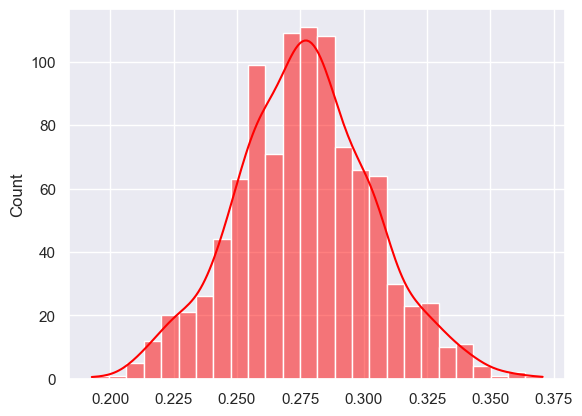

In [36]:
sns.histplot(dist_list, color="red", kde=True)

### Sentence embeddings visualization - Figure 4

We'll follow the tutorial at  https://amitness.com/interactive-sentence-embeddings/.
We'll use the [Sentence Transformers](https://www.sbert.net/) method to generate vector embeddings for each response.

In [37]:
!pip3 install sentence-transformers

In [38]:
from sklearn.model_selection import train_test_split
from sklearn import datasets
from sklearn import svm

from sentence_transformers import SentenceTransformer

In [39]:
# helper function to clean linguistic data
def clean_text(text):
  """ 
  Apply basic pre-processing to remove newlines, etc.
  """
  text = text.replace("\n", "")
  text = text.strip()
  return text

In [40]:
# Load responses from explanation prompt
explanations = pd.read_csv(csv_dir + "pedagogy_exp2_outputs.csv")
explanations.response = explanations.response.apply(clean_text)

# Load responses from description prompt
descriptions = pd.read_csv(csv_dir + "baseline_exp1_outputs.csv")
descriptions.response = descriptions.response.apply(clean_text)

In [41]:
descriptions.shape

(120, 3)

In [42]:
explanations.shape

(118, 3)

In [43]:
cdf = pd.concat((explanations, descriptions), axis=0)
cdf.shape

(238, 3)

In [44]:
sentences = list(cdf.response)

### Create sentence embeddings

In [45]:
model = SentenceTransformer('multi-qa-MiniLM-L6-cos-v1')

In [46]:
embeddings = model.encode(sentences)

In [47]:
embeddings.shape

(238, 384)

### Saving outputs and metadata

In [48]:
# Convert NumPy array of embedding into data frame
embedding_df = pd.DataFrame(embeddings)

# Save dataframe as as TSV file without any index and header
embedding_df.to_csv('output.tsv', sep='\t', index=None, header=None)

In [49]:
metadata = cdf
metadata.shape

(238, 3)

In [50]:
metadata.to_csv('metadata.tsv', index=False, sep='\t')

## Exploring the embeddings

1. To view the projection: https://projector.tensorflow.org/?config=https://gist.githubusercontent.com/ronentk/f75e73102681dc96aff5535beb587a17/raw/b9d093739abee4302ca0c61f9e4d56e1d7250edc/config.json

- UMAP is stochastic, so each run will give different results. I saved a run that produces a nice visualization, it can be viewed by loading the "view 1" bookmark on the bottom right. It should look something like below (blue is pedagogical, red is baseline):


![title](./embeddings_display.png)

# Question 3: How well do the concepts invoked in the response map onto the task environment?

In [51]:
# read annotated data (with taggings)
description_annotations = []
explanation_annotations = []
for line in open(json_dir + 'cliphy_exp_pilot2_pedagogy.jsonl', 'r'):
    explanation_annotations.append(json.loads(line))
for line in open(json_dir + 'cliphy_exp_pilot1_baseline.jsonl', 'r'):
    description_annotations.append(json.loads(line))

In [52]:
# one-hot encoding for 13 tags of key concepts
explanation_features = {'initial impulse': 0, 'mass': 0, 'wind': 0, 'gravity': 0, 'direction': 0, 'rho': 0, 'circle': 0, 'background image': 0, 'misc.': 0, 'paddle': 0, 'reference': 0, 'arrow': 0, 'color of the balls': 0}
for annotation in explanation_annotations:
    for label in [tag[-1] for tag in annotation['label']]:
        explanation_features[label] += 1

    
description_features = {'initial impulse': 0, 'mass': 0, 'wind': 0, 'gravity': 0, 'direction': 0, 'rho': 0, 'circle': 0, 'background image': 0, 'misc.': 0, 'paddle': 0, 'reference': 0, 'arrow': 0, 'color of the balls': 0}
for annotation in description_annotations:
    for label in [tag[-1] for tag in annotation['label']]:
        description_features[label] += 1

In [53]:
# display and compute the number of each tag mentioned in explanations
explanation_df = pd.DataFrame(explanation_features.items(), columns=['label', 'value'])
explanation_df['cond'] = 'explanation'
explanation_df['norm'] = explanation_df['value']/explanation_df['value'].sum()
# explanation_df['label'] = ['mass','direction','initial impulse','gravity','wind','rho','misc.','reference','arrow','paddle','circle','background image','color of the balls']
explanation_df

,label,value,cond,norm
0,initial impulse,76,explanation,0.078756
1,mass,123,explanation,0.127461
2,wind,43,explanation,0.044560
3,gravity,75,explanation,0.077720
4,direction,111,explanation,0.115026
5,rho,35,explanation,0.036269
6,circle,34,explanation,0.035233
7,background image,146,explanation,0.151295
8,misc.,6,explanation,0.006218
9,paddle,52,explanation,0.053886


In [54]:
# display and compute the number of each tag mentioned in descriptions
description_df = pd.DataFrame(description_features.items(), columns=['label', 'value'])
description_df['cond'] = 'description'
description_df['norm'] = description_df['value']/description_df['value'].sum()
description_df

,label,value,cond,norm
0,initial impulse,26,description,0.052632
1,mass,13,description,0.026316
2,wind,5,description,0.010121
3,gravity,16,description,0.032389
4,direction,2,description,0.004049
5,rho,9,description,0.018219
6,circle,70,description,0.141700
7,background image,97,description,0.196356
8,misc.,10,description,0.020243
9,paddle,59,description,0.119433


In [55]:
df_combined = pd.concat([explanation_df, description_df])
df_combined

,label,value,cond,norm
0,initial impulse,76,explanation,0.078756
1,mass,123,explanation,0.127461
2,wind,43,explanation,0.044560
3,gravity,75,explanation,0.077720
4,direction,111,explanation,0.115026
5,rho,35,explanation,0.036269
6,circle,34,explanation,0.035233
7,background image,146,explanation,0.151295
8,misc.,6,explanation,0.006218
9,paddle,52,explanation,0.053886


In [56]:
# parse out dataframe of physical tags in explanations group and dataframe of visual tags in descriptions group
physical_list = ['initial impulse','mass','rho','gravity','direction','wind']
visual_list = ['circle','background image','paddle','reference','arrow','color of the balls']
df_physical_labels_exp = df_combined.loc[df_combined['cond'].isin(['explanation']) & df_combined['label'].isin(physical_list)]
df_visual_labels_des = df_combined.loc[df_combined['cond'].isin(['description']) & df_combined['label'].isin(visual_list)]
df_misc_labels = df_combined.loc[df_combined['label'] == 'misc.']

In [57]:
# sort dataframes based on the frequency of tags mentioned
# preparing for label frequency display
df_physical_labels_exp = df_physical_labels_exp.sort_values(by=['value'], ascending=False).reset_index(drop=True)
df_visual_labels_des = df_visual_labels_des.sort_values(by=['value'], ascending=True).reset_index(drop=True)
physical_labels_display = df_physical_labels_exp['label'].to_frame().reset_index(drop=True)
visual_labels_display = df_visual_labels_des['label'].to_frame().reset_index(drop=True)

In [58]:
# combined the sorted dataframes - physical labels first, visual labels second
df_physical_combined = df_combined.loc[df_combined['label'].isin(physical_list)]
df_visual_combined = df_combined.loc[df_combined['label'].isin(visual_list)]
df_physical_combined = physical_labels_display.merge(df_physical_combined, on=['label'])
df_visual_combined = visual_labels_display.merge(df_visual_combined, on=['label'])
df_combined = pd.concat([df_physical_combined, df_misc_labels, df_visual_combined])

# change label names for clarification
df_combined.loc[df_combined["label"] == "initial impulse", "label"] = "launching force"
df_combined.loc[df_combined["label"] == "rho", "label"] = "launching position"

### Frequency of different tags - Figure 5

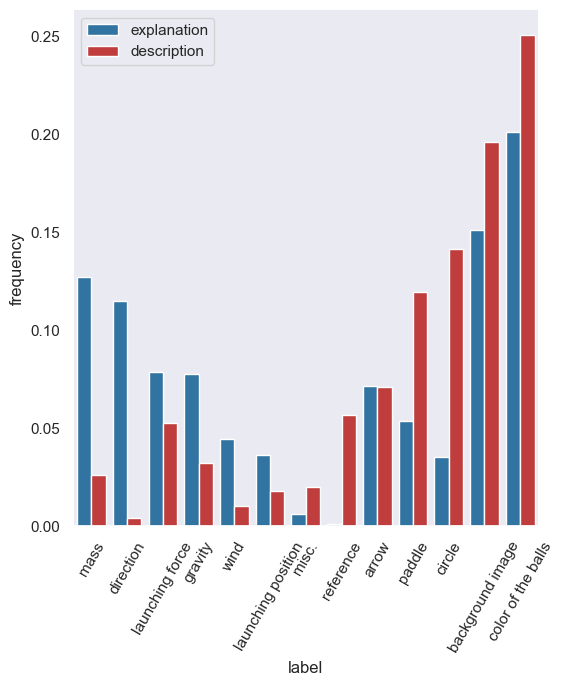

In [59]:
# display the difference in frequency across two conditions
palette = [
    'tab:blue', 'tab:red'
]

# barplot for frequency of tags for two conditions
g = sns.catplot(
    data=df_combined, kind="bar",
    x="label", y="norm", hue="cond",
    palette=palette, alpha=1, height=6,legend=False
)

plt.grid(False)
plt.legend(loc='upper left')
g.despine(left=True)
g.set_axis_labels("label", "frequency")
g.set_xticklabels(rotation=60)

### Chi-square test

In [60]:
%%R -i df_combined


observed_table <- matrix(df_combined$value, nrow = 2, ncol = 13, byrow = T)
rownames(observed_table) <- c("baseline", "pedagogy")
colnames(observed_table) <- c('initial impulse', 'mass', 'wind', 'gravity', 'direction', 'rho', 'circle', 'background image', 'misc.', 'paddle', 'reference', 'arrow', 'color of the balls')
observed_table

         initial impulse mass wind gravity direction rho circle
baseline             123   13  111       2        76  26     75
pedagogy              10    1   28      69        35  52     59
         background image misc. paddle reference arrow color of the balls
baseline               16    43      5        35     9                  6
pedagogy               34    70    146        97   194                124


In [61]:
%%R

X <- chisq.test(observed_table)
X


	Pearson's Chi-squared test

data:  observed_table
X-squared = 638.88, df = 12, p-value < 2.2e-16



In [62]:
err_tag = pd.read_csv(csv_dir + 'err_tag.csv')                                 
with pd.option_context('display.max_rows', None, 'display.max_columns', None):  # more options can be specified also
    display(err_tag)

,gameID,pilot,initial impulse,mass,wind,gravity,direction,rho,circle,background image,misc.,paddle,reference,arrow,color of the balls,causal,procedural,none,angular_err,lang,doc,removed_stops,removed_puncts,removed_stops_puncts,lemmatized,num_words,quantiles,Sv,Sp,sv_above_median,sp_above_median
0,1391-801f25f7-c8db-4e88-8ec2-d9d9f2c66bfa,pilot2,1,0,0,1,1,0,0,1,0,0,0,0,0,1,0,0,29.166697,The gravity zone changes depending on the back...,The gravity zone changes depending on the back...,"['gravity', 'zone', 'changes', 'depending', 'b...","['The', 'gravity', 'zone', 'changes', 'dependi...","['gravity', 'zone', 'changes', 'depending', 'b...","['gravity', 'zone', 'change', 'depend', 'backg...",37,less good,0.166667,0.500000,0,1
1,7724-4935cbf9-1234-4424-9c4b-131fcd76b66d,pilot2,0,1,1,1,1,0,1,1,0,0,0,1,1,1,0,0,35.495190,"Firstly consider gravity in the wheel, as if t...","Firstly consider gravity in the wheel, as if t...","['Firstly', 'consider', 'gravity', 'wheel', ',...","['Firstly', 'consider', 'gravity', 'in', 'the'...","['Firstly', 'consider', 'gravity', 'wheel', 'r...","['firstly', 'consider', 'gravity', 'wheel', 'r...",81,less good,0.666667,0.666667,1,1
2,0299-57faeb83-0ece-4603-925f-0cc4ce1f5f9a,pilot2,0,1,0,1,1,1,1,1,0,0,0,0,1,1,0,0,18.359989,"In both maps there is gravity, in the plain ro...","In both maps there is gravity, in the plain ro...","['maps', 'gravity', ',', 'plain', 'room', 'pul...","['In', 'both', 'maps', 'there', 'is', 'gravity...","['maps', 'gravity', 'plain', 'room', 'pulls', ...","['map', 'gravity', 'plain', 'room', 'pull', 's...",74,good,0.500000,0.666667,1,1
3,0788-34b7a95d-127c-4a7e-a8a5-a0e039f20fa0,pilot2,1,1,0,1,1,0,0,1,0,0,0,0,1,1,0,0,13.759829,Imagine gravity changes depending on which roo...,Imagine gravity changes depending on which roo...,"['Imagine', 'gravity', 'changes', 'depending',...","['Imagine', 'gravity', 'changes', 'depending',...","['Imagine', 'gravity', 'changes', 'depending',...","['imagine', 'gravity', 'change', 'depend', 'ro...",87,good,0.333333,0.666667,1,1
4,5213-b204763b-d5ef-4300-bc4b-faa9bb6837de,pilot2,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,36.810402,learn the pattern of path for each ball then m...,learn the pattern of path for each ball then m...,"['learn', 'pattern', 'path', 'ball', 'memorize...","['learn', 'the', 'pattern', 'of', 'path', 'for...","['learn', 'pattern', 'path', 'ball', 'memorize...","['learn', 'pattern', 'path', 'ball', 'memorize...",22,less good,0.000000,0.000000,0,0
5,7314-e68d9850-248a-48f0-a80b-22c9f5bcebf6,pilot2,0,1,1,1,1,0,0,1,0,0,0,0,0,1,0,0,24.641236,Take notice of which ball does what - they act...,Take notice of which ball does what - they act...,"['notice', 'ball', '-', 'act', 'like', 'differ...","['Take', 'notice', 'of', 'which', 'ball', 'doe...","['notice', 'ball', 'act', 'like', 'different',...","['notice', 'ball', 'act', 'like', 'different',...",52,less good,0.166667,0.666667,0,1
6,7331-a8125de2-b698-4cdc-aa1d-601119d50e3a,pilot2,0,0,0,1,1,0,0,1,0,0,0,0,1,1,1,0,44.956791,In the first room I think gravity is normal an...,In the first room I think gravity is normal an...,"['room', 'think', 'gravity', 'normal', 'second...","['In', 'the', 'first', 'room', 'I', 'think', '...","['room', 'think', 'gravity', 'normal', 'second...","['room', 'think', 'gravity', 'normal', 'second...",48,less bad,0.333333,0.333333,1,1
7,7315-851d45a8-0dfa-4ecd-b7c0-225b907dc20e,pilot2,1,1,0,1,0,1,0,0,0,0,0,0,1,1,0,0,37.275768,Remember the balls will fall according to the ...,Remember the balls will fall according to the ...,"['Remember', 'balls', 'fall', 'according', 'la...","['Remember', 'the', 'balls', 'will', 'fall', '...","['Remember', 'balls', 'fall', 'according', 'la...","['remember', 'ball', 'fall', 'accord', 'law', ...",47,less bad,0.166667,0.666667,0,1
8,8134-fed12613-6d0f-4453-b326-4bb7f92884b5,pilot2,1,0,0,0,1,0,0,1,0,0,0,1,1,0,1,0,28.914241,The balls all break a different way based on w...,The balls all break a different way based on w...,"['balls', 'break', 'diffe

In [63]:
# the Sp & Sv in the above file is calculated in the following way, try it yourself!
# # sets of key concepts in two domains
# PHYS_CONCEPTS = ['initial impulse', 'mass', 'wind', 'gravity', 'direction', 'rho']
# VIS_CONCEPTS = ['circle', 'background image', 'paddle', 'reference', 'arrow', 'color of the balls']

# # helper function to calculate recall values
# def calc_recall(row, concept_set):
#     return row[concept_set].sum() / len(concept_set)

# # calculate recall values
# err_tag["Sv"] = err_tag.apply(lambda row: calc_recall(row, VIS_CONCEPTS), axis=1)
# err_tag["Sp"] = err_tag.apply(lambda row: calc_recall(row, PHYS_CONCEPTS), axis=1)

In [64]:
stats.pearsonr(err_tag['angular_err'], err_tag['Sp'])

(-0.32519166692962675, 0.0003268285215649892)

In [65]:
stats.pearsonr(err_tag['angular_err'], err_tag['Sv'])

(-0.17535266332891858, 0.05752715072531075)

### causal vs. procedual prevalence pie chart

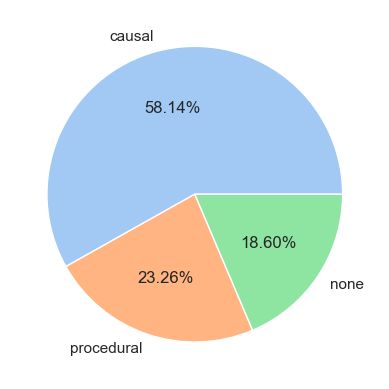

In [66]:
#define data
proportions = err_tag[['causal', 'procedural', 'none']].sum().values
labels = ['causal', 'procedural', 'none']

#define Seaborn color palette to use
colors = sns.color_palette('pastel')[0:5]

#create pie chart, reserve two digits after the decimal point
plt.pie(proportions, labels = labels, colors = colors, autopct='%.2f%%')
plt.show()

# Question 4: How are explanations associated with game performance?

### performance analysis using median

In [67]:
# Visual recall median
med_sv = err_tag.Sv.median()
med_sv

0.333333333

In [68]:
# physical recall median
med_sp = err_tag.Sp.median()
med_sp

0.333333333

### Two sample t-test for RMSE difference for above median physical recall Rv and below median Rv

In [69]:
Cond1 = err_tag[err_tag['sv_above_median']==True].angular_err
Cond2 = err_tag[err_tag['sv_above_median']==False].angular_err
%Rpush Cond1 Cond2

In [70]:
Cond1.mean()

35.752325959655174

In [71]:
Cond2.mean()

39.41413414000001

In [72]:
%%R

t.test(x=Cond2, y=Cond1, var.equal = TRUE)


	Two Sample t-test

data:  Cond2 and Cond1
t = 1.1061, df = 116, p-value = 0.271
alternative hypothesis: true difference in means is not equal to 0
95 percent confidence interval:
 -2.895154 10.218770
sample estimates:
mean of x mean of y 
 39.41413  35.75233 



### Two sample t-test for RMSE difference for above median visual recall Rp and below median Rp

In [73]:
Cond1 = err_tag[err_tag['sp_above_median']==True].angular_err
Cond2 = err_tag[err_tag['sp_above_median']==False].angular_err
%Rpush Cond1 Cond2

print (Cond1.mean())
print (Cond2.mean())

32.035121244363644
42.48494104158732


In [74]:
%%R

t.test(x=Cond2, y=Cond1, var.equal = TRUE)


	Two Sample t-test

data:  Cond2 and Cond1
t = 3.2749, df = 116, p-value = 0.001394
alternative hypothesis: true difference in means is not equal to 0
95 percent confidence interval:
  4.129819 16.769821
sample estimates:
mean of x mean of y 
 42.48494  32.03512 



### Proportions of causal and procedural explanations in different performance groups

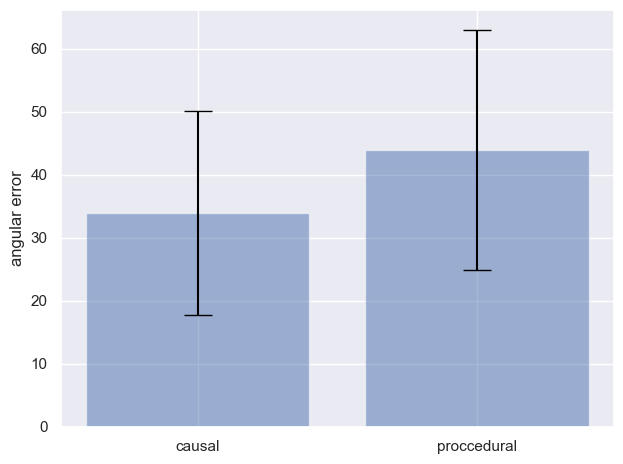

In [75]:
causal_df = err_tag[err_tag['causal']==1]
procedural_df = err_tag[err_tag['causal']==0]

causal_err_mean = np.mean(causal_df['angular_err'].tolist())
procedural_err_mean = np.mean(procedural_df['angular_err'].tolist())
causal_err_std = np.std(causal_df['angular_err'].tolist())
procedural_err_std = np.std(procedural_df['angular_err'].tolist())

names = ['causal', 'proccedural']
x_pos = np.arange(len(names))
means = [causal_err_mean, procedural_err_mean]
error = [causal_err_std, procedural_err_std]

fig, ax = plt.subplots()
ax.bar(x_pos, means, yerr=error, align='center', alpha=0.5, ecolor='black', capsize=10)
ax.set_ylabel('angular error')
ax.set_xticks(x_pos)
ax.set_xticklabels(names)
ax.yaxis.grid(True)

# Save the figure and show
plt.tight_layout()
plt.show()

### RMSE of causal vs. procedural explanations

In [76]:
causal_err_mean

33.9644146348

In [77]:
procedural_err_mean

43.98027573139535

### Two sample t-test for RMSE of causal vs. procedural explanations
h0: RMSE_causal - RMSE_procedural = 0 \
h1: RMSE_causal - RMSE_procedural != 0

In [78]:
Cond1 = causal_df.angular_err
Cond2 = procedural_df.angular_err

%Rpush Cond1 Cond2

In [79]:
%%R

t.test(x=Cond2, y=Cond1, var.equal = TRUE)


	Two Sample t-test

data:  Cond2 and Cond1
t = 3.0081, df = 116, p-value = 0.003224
alternative hypothesis: true difference in means is not equal to 0
95 percent confidence interval:
  3.421163 16.610559
sample estimates:
mean of x mean of y 
 43.98028  33.96441 



### Proportions of causal and procedural explanations in different performance groups

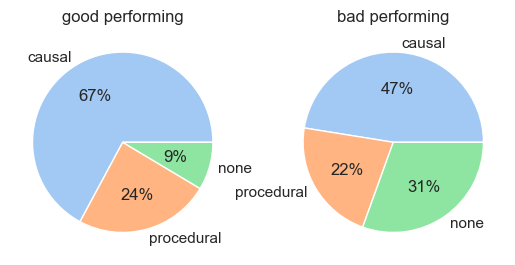

In [80]:
good_df = err_tag[(err_tag['quantiles']=='good')|(err_tag['quantiles']=='less good')]
bad_df = err_tag[(err_tag['quantiles']=='bad')|(err_tag['quantiles']=='less bad')]

labels = ['causal', 'procedural', 'none']
colors = sns.color_palette('pastel')[0:5]

f, (ax1, ax2) = plt.subplots(1, 2, sharey=True)

proportions_good = good_df[['causal', 'procedural', 'none']].sum().values
ax1.pie(proportions_good, labels = labels, colors = colors, autopct='%.0f%%')
ax1.set_title("good performing")
proportions_bad = bad_df[['causal', 'procedural', 'none']].sum().values
ax2.pie(proportions_bad, labels = labels, colors = colors, autopct='%.0f%%')
ax2.set_title("bad performing")
plt.show()

### Figure 6

In [81]:
proportions_above = tuple((proportions_good/proportions_good.sum()).round(decimals=2))
proportions_above

(0.67, 0.24, 0.09)

In [82]:
proportions_below = tuple((proportions_bad/proportions_bad.sum()).round(decimals=2))
proportions_below

(0.47, 0.22, 0.31)

In [83]:
causal_group = (proportions_above[0], proportions_below[0])
procedural_group = (proportions_above[1], proportions_below[1])
none_group = (proportions_above[2], proportions_below[2])

width = 0.5

In [84]:
causal_group = np.asarray(causal_group)
procedural_group = np.asarray(procedural_group)
none_group = np.asarray(none_group)

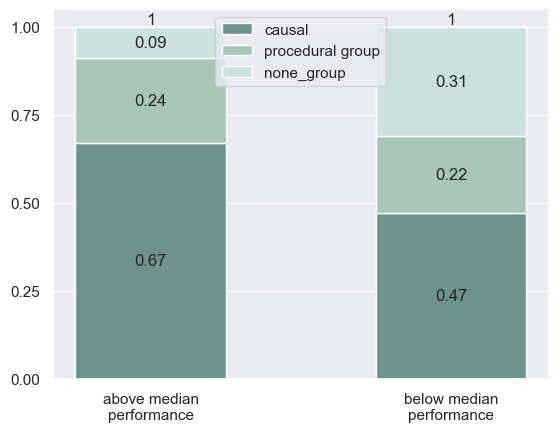

In [87]:
ind = ['above median\nperformance', 'below median\nperformance']
yticks = [0.00, 0.25, 0.50, 0.75, 1.00]

fig, ax = plt.subplots()

p1 = ax.bar(ind, causal_group, width, label='causal', color='#6e928c')
p2 = ax.bar(ind, procedural_group, width, bottom=causal_group, label='procedural group', color='#a7c6b8')
p3 = ax.bar(ind, none_group, width, bottom=procedural_group+causal_group, label='none_group', color='#c9e2de')

ax.axhline(0, color='grey', linewidth=0.8)
# ax.set_title('Proportions of causal and procedural explanations in different performance groups')
ax.set_xticks(ind)
ax.set_yticks(yticks)
ax.legend(loc='upper center')

# Label with label_type 'center' instead of the default 'edge'
ax.bar_label(p1, label_type='center')
ax.bar_label(p2, label_type='center')
ax.bar_label(p3, label_type='center')
ax.bar_label(p3)

plt.show()

### Chi-squared test for figure 6

In [ ]:
pie = good_df[['causal', 'procedural', 'none']].sum().tolist()+bad_df[['causal', 'procedural', 'none']].sum().tolist()
%Rpush pie

In [ ]:
%%R

observed_table <- matrix(unlist(pie), nrow = 2, ncol = 3, byrow = T)
rownames(observed_table) <- c("baseline", "pedagogy")
colnames(observed_table) <- c('initial impulse', 'mass', 'wind')
observed_table

In [ ]:
%%R 

chisq.test(observed_table)